# MEDIAR Training and Prediction Tutorial

This tutorial guides how to conduct prediction using pretrained models from both MEDIARs final challenge weights as well as weights that were trained on data from the LPBS laboratory.



---


## 1. Setup

Clone Github repository and install dependencies.

In [ ]:
# Clone MEDIAR github repo
!git clone https://github.com/Lee-Gihun/MEDIAR.git
%rm -rf ./sample_data
%cd MEDIAR

# # Install dependencies
%pip install -r requirements.txt
%pip install segmentation-models-pytorch==0.3.1
%pip install wandb
!wandb off

Cloning into 'MEDIAR'...
remote: Enumerating objects: 509, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 509 (delta 29), reused 35 (delta 17), pack-reused 460
Receiving objects: 100% (509/509), 15.30 MiB | 10.95 MiB/s, done.
Resolving deltas: 100% (268/268), done.
/content/MEDIAR
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.3/137.3 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.7/939.7 kB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.6/500.6 kB 45.3 MB/s eta 0:00:00




---


### 2. Downloading data and preprocessing


In [ ]:
# Download MEDIAR pretrained weights
%mkdir weights
%mkdir weights/pretrained

!gdown --id 1NHDaYvsYz3G0OCqzegT-bkNcly2clPGR -O ./weights/pretrained/
!gdown --id 1v5tYYJDqiwTn_mV0KyX5UEonlViSNx4i -O ./weights/pretrained/

# Download MEDIAR finetuned weights
%mkdir weights/finetuned

!gdown --id 168MtudjTMLoq9YGTyoD2Rjl_d3Gy6c_L -O ./weights/finetuned/from_phase1.pth
!gdown --id 1JJ2-QKTCk-G7sp5ddkqcifMxgnyOrXjx -O ./weights/finetuned/from_phase2.pth

In [ ]:
# All imports we will need
import torch
import glob
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np

from train_tools import *
from train_tools.models import MEDIARFormer
from core.MEDIAR import Predictor, EnsemblePredictor

import os
import imageio

import shutil
import cv2

import tifffile as tif

Download lab dataset:


In [ ]:
google_drive_link = 'https://drive.google.com/file/d/1Drd7fEaxcL2TPMmqO2D2qJ5yN_KTLsdP/view?usp=drive_link'

!gdown --id 1Drd7fEaxcL2TPMmqO2D2qJ5yN_KTLsdP
!unzip "lab dataset.zip"

In [ ]:
#Remove the download and unzipped file so we save space
!rm "lab dataset.zip"

Some preprocessing so that we can use the model with lab data:
In particular, the labs data has the grayscale channel in the first position (for example the shape of an image of dimensions 512x512 is 1x512x512) and we need it in the last position (512x512x1).

We also then stack the grayscale channel 3 times to create an RGB image, as MEDIAR requires this.

NOTE: this preprocessing is ONLY needed for training and inference. When evaluating our predictions against the ground truth, this preprocessing is not needed.

In [ ]:

def process_and_save_image(input_path, output_path):
    # Read the image using imageio
    img = imageio.imread(input_path)

    if len(img.shape) != 3:
      img = img[np.newaxis, :,:]

    #Transpose the dimensions
    img_transformed = np.transpose(img, (1, 2, 0))
    rgb = np.stack([img_transformed]*3, axis=2)
    rgb = rgb[:,:,:,0]

    # Save the processed image to the output path
    imageio.imsave(output_path, rgb)

def process_images_in_directory(input_dir, output_dir):
    # Walk through the directory structure recursively
    for root, dirs, files in os.walk(input_dir):
        for filename in files:
            # Check if the file has a valid image extension
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):

                # Construct the full path to the input image
                input_image_path = os.path.join(root, filename)

                # Construct the corresponding output path
                output_image_path = os.path.join(output_dir, os.path.relpath(input_image_path, input_dir))

                # Ensure the output directory structure exists
                os.makedirs(os.path.dirname(output_image_path), exist_ok=True)
                try:
                  # Process and save the image
                  process_and_save_image(input_image_path, output_image_path)
                except:
                  img = imageio.imread(input_image_path)
                  print(img.shape)

In [ ]:
#Transform the labs data, this will be used ONLY for training the model and inference
input_directory = '/content/MEDIAR/YeaZ_universal_images_and_masks'
output_directory = '/content/MEDIAR/lab_data_transformed'

process_images_in_directory(input_directory, output_directory)

We now separate images in all subfolders of the labs dataset into only 2 subfolders: images and labels.

In [ ]:
def separate_images_in_directory(input_dir, output_dir_images, output_dir_labels):
    os.makedirs('/content/MEDIAR/lab_data_separated', exist_ok = True)
    os.makedirs(output_dir_images, exist_ok = True)
    os.makedirs(output_dir_labels, exist_ok = True)
    # Walk through the directory structure recursively
    for root, dirs, files in os.walk(input_dir):
        for filename in files:
            # Check if the file has a valid image extension
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                # Construct the full path to the input image
                input_image_path = os.path.join(root, filename)

                # Determine the output directory based on the image filename
                if 'mask' in filename.lower():
                    output_dir = output_dir_labels
                else:
                    output_dir = output_dir_images


                # Construct the corresponding output path
                output_image_path = os.path.join(output_dir, filename)


                shutil.copy2(input_image_path, output_image_path)



In [ ]:
#Separate the transformed lab data into just two folders: images and labels
input_directory = '/content/MEDIAR/lab_data_transformed'
output_directory_images = '/content/MEDIAR/lab_data_separated/images'
output_directory_labels = '/content/MEDIAR/lab_data_separated/labels'

separate_images_in_directory(input_directory, output_directory_images, output_directory_labels)

Now we download a small test set which will be used to evaluate our model.

In [ ]:
#Download lab test set
google_drive_link = 'https://drive.google.com/file/d/1hAUfb5RXWfYzDcCg481PY7Wv10m7ZYdx/view?usp=drive_link'

!gdown --id 1hAUfb5RXWfYzDcCg481PY7Wv10m7ZYdx
!unzip "test_images.zip"

Separate the test data into labels and images, as well as renaming files to be able to used by MEDIAR

In [ ]:
def separate_images_in_directory_test(input_dir, output_dir_images, output_dir_labels):
    os.makedirs('/content/MEDIAR/lab_test_separated', exist_ok = True)
    os.makedirs(output_dir_images, exist_ok = True)
    os.makedirs(output_dir_labels, exist_ok = True)
    # Walk through the directory structure recursively
    for root, dirs, files in os.walk(input_dir):
        for filename in files:
            # Check if the file has a valid image extension (you can modify this condition)
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                # Construct the full path to the input image
                input_image_path = os.path.join(root, filename)

                # Determine the output directory based on the image filename
                if 'mask' in filename.lower():
                    output_dir = output_dir_labels
                else:
                    output_dir = output_dir_images

                #Even though tif and tiff are the same format, the tifffile library has trouble recognizing .tif as .tiff
                if filename.endswith('_im.tif'):
                    # Construct the new filename
                    filename = filename.replace('_im.tif', '_image.tiff')


                # Construct the corresponding output path
                output_image_path = os.path.join(output_dir, filename)

                shutil.copy2(input_image_path, output_image_path)

In [ ]:
#Transform the lab test dataset and separate. This is only used as input to our predictor
input_directory = '/content/MEDIAR/Test_images_for_ML_class_2023'
output_directory = '/content/MEDIAR/lab_test_transformed'

process_images_in_directory(input_directory, output_directory)

input_directory = '/content/MEDIAR/lab_test_transformed'
output_directory_images = '/content/MEDIAR/lab_test_separated/images'
output_directory_labels = '/content/MEDIAR/lab_test_separated/labels'

separate_images_in_directory_test(input_directory, output_directory_images, output_directory_labels)

Preparing all data needed for inference and evaluation

In [ ]:
!mkdir lab_ground_truth
!mkdir temp

In [ ]:
#Create lab data ground truth folder, this is only used when evaluating our predictions (not in the predictor itself), because the evaluation needs lab data without any transformations
# that we did in all other cases
input_directory = '/content/MEDIAR/Test_images_for_ML_class_2023'
output_directory_images = '/content/MEDIAR/temp'
output_directory_labels = '/content/MEDIAR/lab_ground_truth'

separate_images_in_directory(input_directory, output_directory_images, output_directory_labels)

In [ ]:
# Directory path
directory_path = '/content/MEDIAR/lab_ground_truth'

#Rename ground truth labels so our evaluator can match the files correctly. NOTE: tif is the same as tiff, just renamed due to errors
# Iterate through files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('_mask.tif'):
        # Construct the new filename
        new_filename = os.path.join(directory_path, filename.replace('_mask.tif', '_image_label.tiff'))

        # Rename the file
        os.rename(os.path.join(directory_path, filename), new_filename)



Download and replace all files that will be used for training, inference and evaluation.

In [ ]:
#Download files we need to replace

# #evaluate.py
os.remove('/content/MEDIAR/evaluate.py')
!gdown --id 1cslf6tQp-YBcwnyGwuFrTbs5QLUio07x
shutil.move('evaluate.py', '/content/MEDIAR/evaluate.py')

# #generate_mapping.py
os.remove('/content/MEDIAR/generate_mapping.py')
!gdown --id 1ozp6XgLMluUG4QM7aFoQqeDL1r2wVDSA


# #finetuning1.json
os.remove('/content/MEDIAR/config/step2_finetuning/finetuning1.json')
!gdown --id 1RRRWxB2lLrt7tXzZE6_xSLwBECM5dsT4
shutil.move('finetuning1.json', '/content/MEDIAR/config/step2_finetuning/finetuning1.json')

# #measures.py
os.remove('/content/MEDIAR/train_tools/measures.py')
!gdown --id 15_X-a1D-YS0Rx4iUUBALgSwZx7kUg_xp
shutil.move('measures.py', '/content/MEDIAR/train_tools/measures.py')


In [ ]:
! python ./generate_mapping.py --root="/content/MEDIAR"

Make the mapping_tuning mapping empty as we are not using a tuning set

In [ ]:
%%writefile /content/MEDIAR/train_tools/data_utils/mapping_tuning.json
{}

To run the training, uncomment this line. By default, this will use MEDIARS pretrained phase1 weights and train on the entire LPBS dataset for 50 epochs.

In [ ]:
#! python ./main.py --config_path="/content/MEDIAR/config/step2_finetuning/finetuning1.json"

To save our trained weights, we can upload them to our google drive or download them locally

In [ ]:
##Uncomment to download to drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
##Run if we want to copy the trained model to MyDrive
# model_name = "--YOUR_MODEL_NAME--"
# path = f"/content/drive/MyDrive/{model_name}"
# shutil.copy("/content/MEDIAR/wandb/latest-run/files/model.pth", path)

In [ ]:
##Uncomment if we want to download files locally
#from google.colab import files
#files.download('/content/MEDIAR/wandb/latest-run/files/model.pth')

Now we can perform inference on the test set, using our pre-trained models which are uploaded on a Google Drive

In [ ]:
#Download our trained weights
!gdown --id 1gChQsgl7ADADUyVz2pVVAV1kIuwjlOV_
!gdown --id 1vZz5y98XiYa4dKbCuOVMxm1JTJP3oco1

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1gChQsgl7ADADUyVz2pVVAV1kIuwjlOV_
To: /content/MEDIAR/model_pretrained_phase1_50_epochs.pth
100% 486M/486M [00:03<00:00, 143MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1vZz5y98XiYa4dKbCuOVMxm1JTJP3oco1
To: /content/MEDIAR/model_finetuned_phase1_20epochs.pth
100% 486M/486M [00:04<00:00, 105MB/s] 


In [ ]:
!mkdir results

In [ ]:
def conduct_prediction(model_path, input_path, gt_path):
  model_name = (model_path.split('/')[-1]).split('.')[0]
  output_path = f"results/{model_name}"
  !mkdir {output_path}

  weights = torch.load(model_path, map_location="cpu")
  model_args = {
    "classes": 3,
    "decoder_channels": [1024, 512, 256, 128, 64],
    "decoder_pab_channels": 256,
    "encoder_name": 'mit_b5',
    "in_channels": 3
  }
  model = MEDIARFormer(**model_args)
  model.load_state_dict(weights, strict=False)

  predictor = Predictor(model, "cuda:0", input_path, output_path, algo_params={"use_tta": False})
  _ = predictor.conduct_prediction()

  print("Evaluation of model: ", model_name)
  !python ./evaluate.py --pred_path={output_path} --gt_path={gt_path}

def conduct_ensemble_prediction(model_path1, model_path2, input_path, output_path):
  model_name1 = (model_path1.split('/')[-1]).split('.')[0]

  model_name2 = (model_path2.split('/')[-1]).split('.')[0]

  output_path = f"results/ensemble_{model_name1}_and_{model_name2}"
  !mkdir {output_path}


  weights1 = torch.load(model_path1, map_location="cpu")
  weights2 = torch.load(model_path2, map_location="cpu")
  model_args = {
    "classes": 3,
    "decoder_channels": [1024, 512, 256, 128, 64],
    "decoder_pab_channels": 256,
    "encoder_name": 'mit_b5',
    "in_channels": 3
  }
  model1 = MEDIARFormer(**model_args)
  model1.load_state_dict(weights1, strict=False)
  model2 = MEDIARFormer(**model_args)
  model2.load_state_dict(weights2, strict=False)

  predictor3 = EnsemblePredictor(model1, model2, "cuda:0", input_path, output_path, algo_params={"use_tta": True})
  _ = predictor3.conduct_prediction()

  print("Evaluation of ensemble model: ", model_name1, " and ", model_name2)
  !python ./evaluate.py --pred_path={output_path} --gt_path={gt_path}

In [ ]:
model_path1 = "/content/MEDIAR/model_pretrained_phase1_50_epochs.pth"
model_path2 = "/content/MEDIAR/model_finetuned_phase1_20epochs.pth"
#To use the weights from current training, we can define a new path and pass it to the conduct_prediction function as the model_path argument,
#new_model_path = /content/MEDIAR/wandb/latest-run/files/model.pth

finetuned_phase1_model = "/content/MEDIAR/weights/finetuned/from_phase1.pth"
finetuned_phase2_model = "/content/MEDIAR/weights/finetuned/from_phase2.pth"

input_path = "/content/MEDIAR/lab_test_separated/images"
gt_path= "/content/MEDIAR/lab_ground_truth"

In [ ]:
#If we want to redo the inference, we can delete the results and re-do the inference
# shutil.rmtree('/content/MEDIAR/results')
# !mkdir results

In [ ]:
path = "/content/MEDIAR/results/ensemble_model_pretrained_phase1_50_epochs_and_from_phase1/IBC180_004_image_label.tiff"
pred1 = io.imread(path)
io.imshow(pred1, cmap="cividis")

In [ ]:
conduct_prediction(model_path1, input_path, gt_path)
conduct_prediction(model_path2, input_path, gt_path)
conduct_ensemble_prediction(model_path1, model_path2, input_path, gt_path)

conduct_prediction(finetuned_phase1_model, input_path, gt_path)
conduct_prediction(finetuned_phase2_model, input_path, gt_path)
print("Ensemble predictions using MEDIARs finetuned weights as well:")

conduct_ensemble_prediction(model_path1, finetuned_phase1_model, input_path, gt_path)
conduct_ensemble_prediction(model_path1, finetuned_phase2_model, input_path, gt_path)
conduct_ensemble_prediction(finetuned_phase1_model, finetuned_phase2_model, input_path, gt_path)

Prediction finished: IBC180_004_image.tif; img size = torch.Size([1, 3, 512, 512]); costing: 0.56s
Prediction finished: OD301_01_image.tif; img size = torch.Size([1, 3, 512, 512]); costing: 0.36s
Prediction finished: YSM3919_pak2Dcdc42mChSW_24h_04_R3D_image.tif; img size = torch.Size([1, 3, 1024, 1024]); costing: 2.68s
Prediction finished: pSP_99_crop_1_image.tiff; img size = torch.Size([1, 3, 921, 1580]); costing: 4.11s
Prediction finished: pSP_99_crop_2_image.tiff; img size = torch.Size([1, 3, 580, 1080]); costing: 1.28s

 Total Time Cost: 8.99s
Evaluation of model:  model_pretrained_phase1_50_epochs
100% 5/5 [00:01<00:00,  3.29it/s]
mean F1 Score: 0.96846
mean AP Score: 0.9394200000000001
Prediction finished: IBC180_004_image.tif; img size = torch.Size([1, 3, 512, 512]); costing: 0.53s
Prediction finished: OD301_01_image.tif; img size = torch.Size([1, 3, 512, 512]); costing: 0.38s
Prediction finished: YSM3919_pak2Dcdc42mChSW_24h_04_R3D_image.tif; img size = torch.Size([1, 3, 1024, 1

Some visualizations of the predicted labels

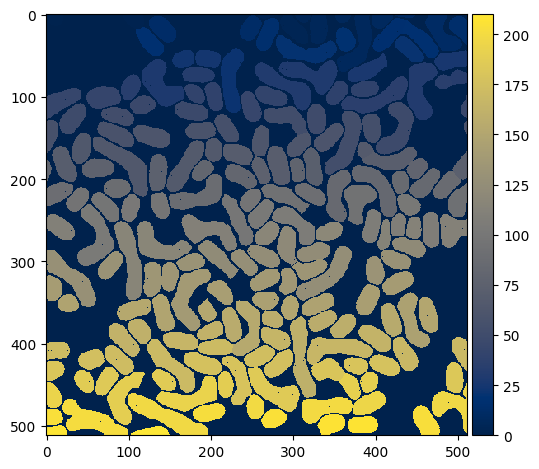

In [ ]:
path = "/content/MEDIAR/results/ensembe_model_pretrained_phase1_50_epochs_and_model_finetuned_phase1_20epochs/IBC180_004_image_label.tiff"
pred1 = io.imread(path)
io.imshow(pred1, cmap="cividis")

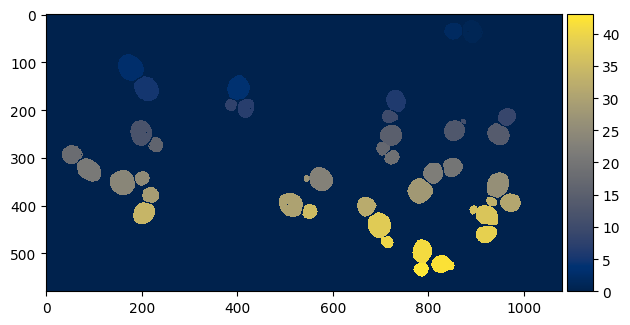

In [ ]:
path = "/content/MEDIAR/results/ensembe_model_pretrained_phase1_50_epochs_and_model_finetuned_phase1_20epochs/pSP_99_crop_2_image_label.tiff"

pred1 = io.imread(path)
io.imshow(pred1, cmap="cividis")

134


/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


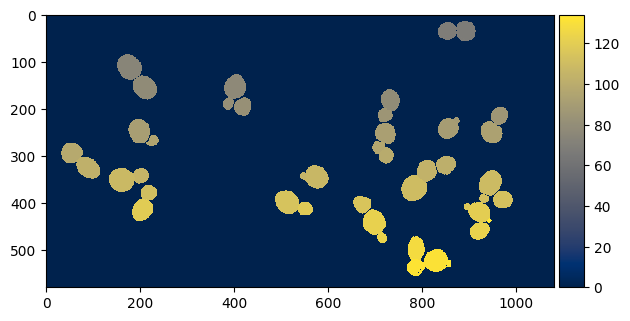

In [ ]:
path = "/content/MEDIAR/lab_ground_truth/pSP_99_crop_2_image_label.tiff"
pred1 = io.imread(path)
print(pred1.max())
io.imshow(pred1, cmap="cividis")

7186


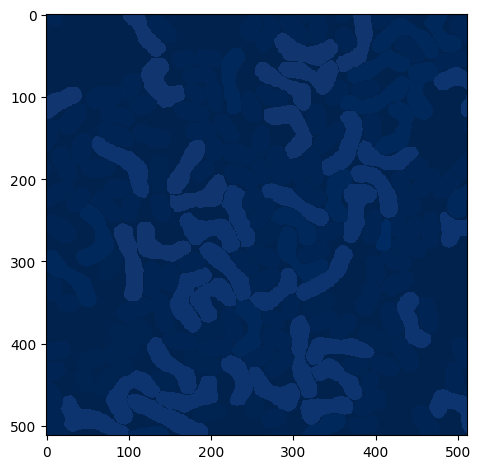

In [ ]:
path = "/content/MEDIAR/lab_ground_truth/IBC180_004_image_label.tiff"
pred1 = io.imread(path)
print(pred1.max())
io.imshow(pred1, cmap="cividis")



---